# Kaggle Project

## MIT-BIH Arrhythmia Database
The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979.  Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range.  Two or more cardiologists independently annotated each record; disagreements were resolved to obtain the computer-readable reference annotations for each beat (approximately 110,000 annotations in all) included with the database.

**URL:**
- (Preprocessed dataset) https://www.kaggle.com/datasets/raiyanjahangir1939/ecg-arrhythmia-mitbih-dataset
- (Raw dataset) https://www.kaggle.com/datasets/mondejar/mitbih-database

**Task:**

...

...

**Datasets**

* Train dataset: ...

* Validation dataset: ...

* Test dataset: ...

**Features(x):**

...

...

**Target(y):**

...

...

---

## Build Your Model

### Data preprocessing

In [42]:
import torch
import torchvision
import torchmetrics
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
from pathlib import Path
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

In [43]:
drivepath = Path(r'F:/jaeho/SLCL/과제/M3DT/study/Biosignals')
datapath = drivepath / 'mitbih_data_split'

df_train = pd.read_csv(datapath / 'mitbih_train.csv', header = None)
df_test = pd.read_csv(datapath / 'mitbih_test.csv', header = None)

In [44]:
#
y_train = df_train[187].values.reshape(len(df_train[187]), 1)
y_test = df_test[187].values.reshape(len(df_test[187]), 1)

X_train = df_train.iloc[:, :-1].values
X_train = X_train.reshape(len(X_train), X_train.shape[1])

X_test = df_test.iloc[:, :-1].values
X_test = X_test.reshape(len(X_test), X_test.shape[1])

#dataset의 형태를 tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_train = y_train.flatten()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
y_test_tensor = y_test_tensor.flatten()

In [45]:
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_train,
    y_train,
    test_size = 0.25,
    random_state = 0,
    shuffle = True,
    stratify = y_train,
)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


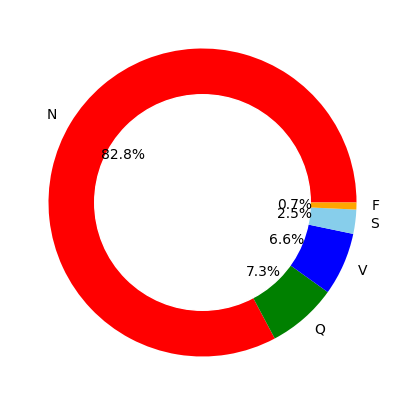

In [46]:
label_count_train = df_train[187].value_counts()
print(label_count_train)

plt.figure(figsize=(10,5))
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(label_count_train, labels=['N','Q','V','S','F'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


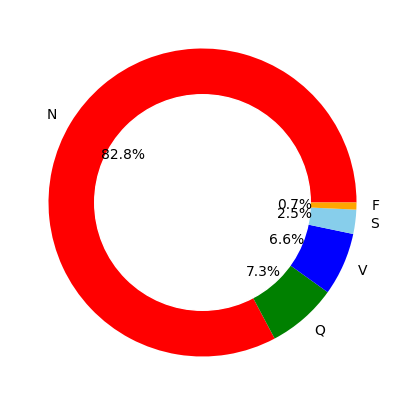

In [47]:
label_count_test = df_test[187].value_counts()
print(label_count_test)

plt.figure(figsize=(10,5))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(label_count_test, labels=['N','Q','V','S','F'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [48]:
#Plot Confusion matrix and score function

class plot_score():
    
    def plot_confusion_matrix(y_true, y_pred):
        classes=['N', 'S', 'V', 'F', 'Q']
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Plot the confusion matrix
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Greens)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=classes,
            yticklabels=classes,
            xlabel='Predicted label',
            ylabel='True label',
            aspect='equal',
            )
        plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
        plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
        plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
        plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center", fontweight='bold',
                        color="white" if cm[i, j] > cm.max() / 2. else "black")
        fig.tight_layout()
        plt.show()
        
    def score_train(y_true, y_pred):
        accuracy_train = accuracy_score(y_true, y_pred)*100
        precision_train = precision_score(y_true, y_pred, average='macro')*100
        recall_train = recall_score(y_true, y_pred, average='macro')*100
        f1_train = f1_score(y_true, y_pred, average='macro')*100
        print("Accuracy (Train): {:.4f}".format(accuracy_train))
        print("Precision (Train): {:.4f}".format(precision_train))
        print("Recall (Train): {:.4f}".format(recall_train))
        print("F1 score (Train): {:.4f}".format(f1_train))
        return accuracy_train, precision_train, recall_train, f1_train
    
    def score_val(y_true, y_pred):
        accuracy_val = accuracy_score(y_true, y_pred)*100
        precision_val = precision_score(y_true, y_pred, average='macro')*100
        recall_val = recall_score(y_true, y_pred, average='macro')*100
        f1_val = f1_score(y_true, y_pred, average='macro')*100
        print("Accuracy (Validation): {:.4f}".format(accuracy_val))
        print("Precision (Validation): {:.4f}".format(precision_val))
        print("Recall (Validation): {:.4f}".format(recall_val))
        print("F1 score (Validation): {:.4f}".format(f1_val))
        return accuracy_val, precision_val, recall_val, f1_val
        
    def score_test(y_true, y_pred):
        accuracy_test = accuracy_score(y_true, y_pred)*100
        precision_test = precision_score(y_true, y_pred, average='macro')*100
        recall_test = recall_score(y_true, y_pred, average='macro')*100
        f1_test = f1_score(y_true, y_pred, average='macro')*100
        print("Accuracy (Test): {:.4f}".format(accuracy_test))
        print("Precision (Test): {:.4f}".format(precision_test))
        print("Recall (Test): {:.4f}".format(recall_test))
        print("F1 score (Test): {:.4f}".format(f1_test))
        return accuracy_test, precision_test, recall_test, f1_test

### Model Construction

In [49]:
# Support Vector Machine

svm = SVC(C=1.0, kernel='rbf', gamma='scale')


# Logistic Regression

lr = LogisticRegression(fit_intercept=True, solver='lbfgs', random_state=0)


# Decision Tree

dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=20, random_state=0)


# Linear Neural Network

hidden_nn = nn.Linear(187, 300, bias=True)
output_nn = nn.Linear(300, 5, bias=True)

model_nn = nn.Sequential(hidden_nn, output_nn)
loss_fn_nn = nn.CrossEntropyLoss()
optimizer_nn = optim.SGD(model_nn.parameters(), lr=0.01)


# Non-Linear Neural Network

hidden_mlp = nn.Linear(187, 300, bias=True)
activation_mlp = nn.ReLU()
output_mlp = nn.Linear(300, 5, bias=True)

model_mlp = nn.Sequential(hidden_mlp, activation_mlp, output_mlp)
loss_fn_mlp = nn.CrossEntropyLoss(reduction = 'sum')
optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=0.01)


# Covolutional Neural Network (1d)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(2, 2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*42, 100),
            nn.ReLU(),
            nn.Linear(100, 5)
        )       
        
    def forward(self,x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*42)
        out = self.fc_layer(out)

        return out

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_cnn = CNN().to(device)

loss_fn_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=0.01)

### Train Model & Select Model

##### SVM

In [50]:
# fit the model on the training data
start_time = time.time()
svm.fit(X_train, y_train)
training_time_svm = time.time() - start_time
y_pred_svm_train = svm.predict(X_train)

# make predictions on the test data
start_time = time.time()
y_pred_svm_test = svm.predict(X_test)
testing_time_svm = time.time() - start_time

##### Logistic Regression

In [51]:
# fit the model on the training data
start_time = time.time()
lr.fit(X_train, y_train)
training_time_lr = time.time() - start_time
y_pred_lr_train = lr.predict(X_train)

# make predictions on the test data
start_time = time.time()
y_pred_lr_test = lr.predict(X_test)
testing_time_lr = time.time() - start_time

g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### Decision Tree

In [52]:
# fit the model on the training data
start_time = time.time()
dt.fit(X_train, y_train)
training_time_dt = time.time() - start_time
y_pred_dt_train = dt.predict(X_train)

# make predictions on the test data
start_time = time.time()
y_pred_dt_test = dt.predict(X_test)
testing_time_dt = time.time() - start_time

##### Linear NN

In [53]:
history_nn = []

start_time = time.time()
for step in tqdm(range(300)):
    y_pred_nn_train = model_nn(X_train_tensor)
    train_loss = loss_fn_nn(y_pred_nn_train, y_train_tensor)
    
    optimizer_nn.zero_grad()
    train_loss.backward()
    optimizer_nn.step()

    model_nn.eval()
    with torch.no_grad():
        y_pred_nn_val = model_nn(X_val_tensor)
        val_loss = loss_fn_nn(y_pred_nn_val, y_val_tensor)
    history_nn.append({"step": step, "train_loss": train_loss.item(), "eval_loss": val_loss.item()})
training_time_nn = time.time() - start_time

  0%|          | 0/300 [00:00<?, ?it/s]

In [78]:
start_time = time.time()
with torch.no_grad():
    y_pred_nn_test = model_nn(X_test_tensor)
    test_loss = loss_fn_nn(y_pred_nn_test, y_test_tensor)
testing_time_nn = time.time() - start_time

print(test_loss.item())

0.6334203481674194


0.0022889384999871254


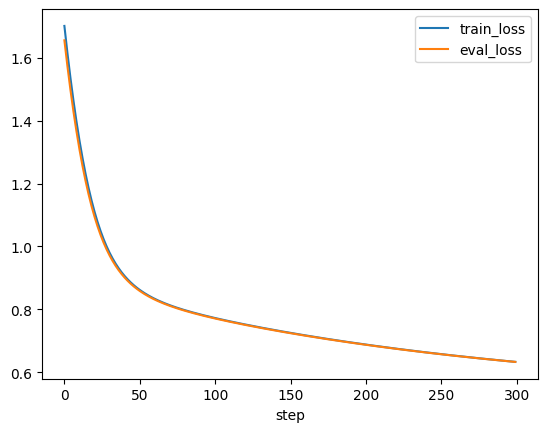

In [75]:
pd.DataFrame(history_nn).plot(x='step', y=['train_loss', 'eval_loss'])

##### Non-Linear NN

In [56]:
history_mlp = []

start_time = time.time()
for step in tqdm(range(300)):
    y_pred_mlp_train = model_mlp(X_train_tensor)
    train_loss = loss_fn_mlp(y_pred_mlp_train, y_train_tensor)
    
    optimizer_mlp.zero_grad()
    train_loss.backward()
    optimizer_mlp.step()

    model_mlp.eval()
    with torch.no_grad():
        y_pred_mlp_val = model_mlp(X_val_tensor)
        val_loss = loss_fn_mlp(y_pred_mlp_val, y_val_tensor)
    history_mlp.append({"step": step, "train_loss": train_loss.item(), "eval_loss": val_loss.item()})
training_time_mlp = time.time() - start_time

  0%|          | 0/300 [00:00<?, ?it/s]

In [57]:
start_time = time.time()
with torch.no_grad():
    y_pred_mlp_test = model_mlp(X_test_tensor)
    test_loss = loss_fn_mlp(y_pred_mlp_test, y_test_tensor)
testing_time_mlp = time.time() - start_time

print(test_loss.item())

0.0022889384999871254


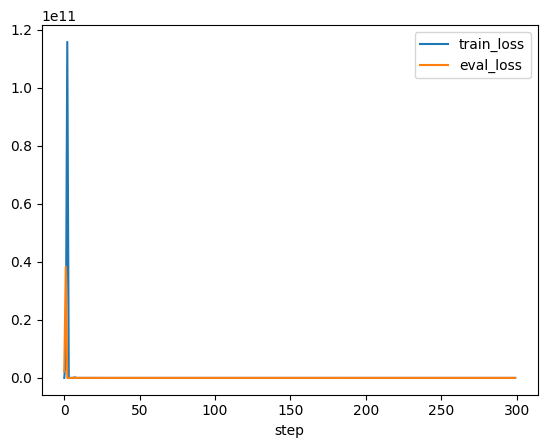

In [76]:
pd.DataFrame(history_mlp).plot(x='step', y=['train_loss', 'eval_loss'])

In [59]:
# Batch training
num_epoch = 300
batch_size = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

history_mlp2 = []

start_time = time.time()
for epoch in tqdm(range(num_epoch)):
    
    train_loss = 0.0
    eval_loss = 0.0
    
    model_mlp.train()
    for batch in train_loader:
        x, y_true = batch
        y_logits_train = model_mlp(x)
        
        loss = loss_fn_mlp(y_logits_train, y_true)
        train_loss += loss
        
        optimizer_mlp.zero_grad()
        loss.backward()
        optimizer_mlp.step()
        
    train_loss /= len(train_dataset)

    model_mlp.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, y_true = batch
            y_logits_val = model_mlp(x)

            loss = loss_fn_mlp(y_logits_val, y_true)
            eval_loss += loss
            
    eval_loss /= len(val_dataset)
    
    history_mlp2.append({
        'epoch': epoch,
        'train_loss': train_loss.item(),
        'eval_loss': eval_loss.item(),
    })
training_time_mlp2 = time.time() - start_time

  0%|          | 0/300 [00:00<?, ?it/s]

In [60]:
test_loss = 0.0

with torch.no_grad():
    start_time = time.time()
    for batch in test_loader:
        x, y_true = batch
        y_logits_test = model_mlp(x)
        loss = loss_fn_mlp(y_logits_test, y_true)
        test_loss += loss
    testing_time_mlp2 = time.time() - start_time
test_loss /= len(test_dataset)

print(test_loss.item())

0.6585787534713745


0.0022889384999871254


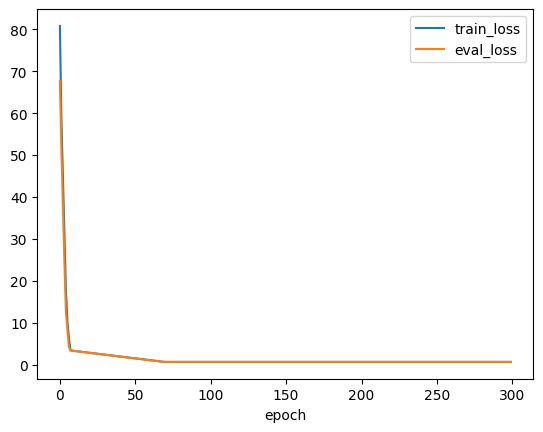

In [77]:
pd.DataFrame(history_mlp2).plot(x='epoch', y=['train_loss', 'eval_loss'])

In [62]:
with torch.no_grad():
    y_pred_mlp2_train = model_mlp(X_train_tensor)
    y_pred_mlp2_val = model_mlp(X_val_tensor)
    y_pred_mlp2_test = model_mlp(X_test_tensor)

##### CNN

In [63]:
num_epoch = 50
batch_size = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

history_cnn = []

start_time = time.time()
for epoch in tqdm(range(num_epoch)):
    
    train_loss = 0.0
    eval_loss = 0.0
    
    model_cnn.train()
    for batch in train_loader:
        x, y_true = batch
        x=x.unsqueeze(1)
        y_logits_train = model_cnn(x)
        
        loss = loss_fn_cnn(y_logits_train, y_true)
        train_loss += loss
        
        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()
        
    train_loss /= len(train_dataset)

    model_cnn.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, y_true = batch
            x=x.unsqueeze(1)
            y_logits_val = model_cnn(x)

            loss = loss_fn_cnn(y_logits_val, y_true)
            eval_loss += loss
            
    eval_loss /= len(val_dataset)
    
    history_cnn.append({
        'epoch': epoch,
        'train_loss': train_loss.item(),
        'eval_loss': eval_loss.item(),
    })
training_time_cnn = time.time() - start_time

  0%|          | 0/300 [00:00<?, ?it/s]

In [64]:
test_loss = 0.0

with torch.no_grad():
    start_time = time.time()
    for batch in test_loader:
        x, y_true = batch
        x=x.unsqueeze(1)
        y_logits_test = model_cnn(x)
        loss = loss_fn_cnn(y_logits_test, y_true)
        test_loss += loss
    testing_time_cnn = time.time() - start_time
test_loss /= len(test_dataset)

print(test_loss.item())

0.0022889384999871254


<built-in method item of Tensor object at 0x0000024DAAC983C0>


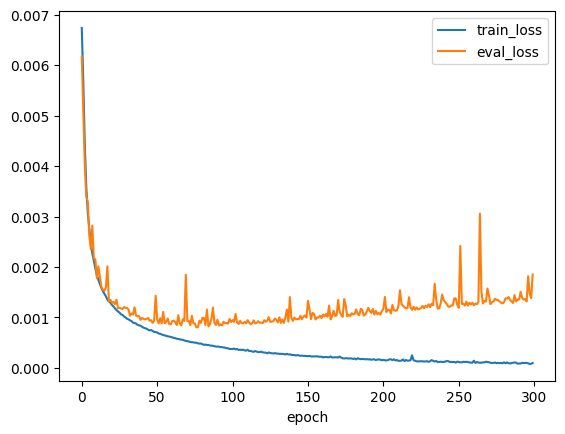

In [65]:
pd.DataFrame(history_cnn).plot(x='epoch', y=['train_loss', 'eval_loss'])

In [66]:
with torch.no_grad():
    y_pred_cnn_train = model_cnn(X_train_tensor.unsqueeze(1))
    y_pred_cnn_val = model_cnn(X_val_tensor.unsqueeze(1))
    y_pred_cnn_test = model_cnn(X_test_tensor.unsqueeze(1))

---

## Performance

##### SVM

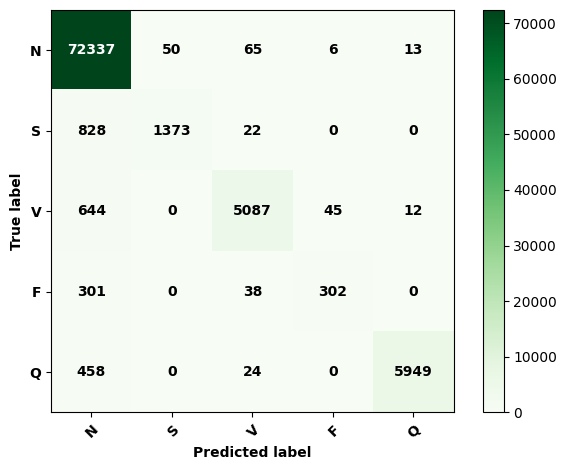

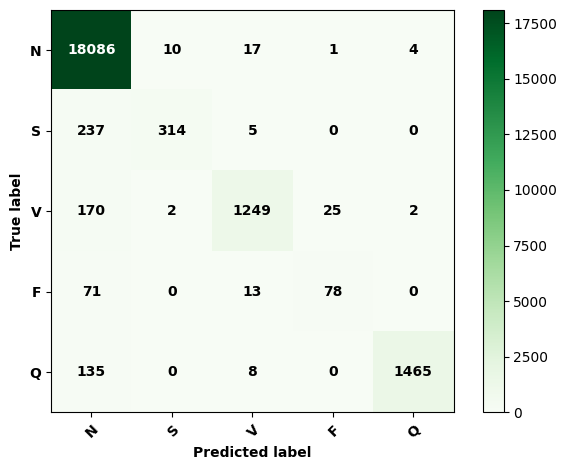

Accuracy (Train): 97.1378
Precision (Train): 95.1565
Recall (Train): 77.8172
F1 score (Train): 84.5348
Accuracy (Test): 96.8025
Precision (Test): 92.8609
Recall (Test): 76.3620
F1 score (Test): 82.8850


In [67]:
plot_score.plot_confusion_matrix(y_train, y_pred_svm_train)
plot_score.plot_confusion_matrix(y_test, y_pred_svm_test)
accuracy_svm_train, precision_svm_train, recall_svm_train, f1_svm_train = plot_score.score_train(y_train, y_pred_svm_train)
accuracy_svm_test, precision_svm_test, recall_svm_test, f1_svm_test = plot_score.score_test(y_test, y_pred_svm_test)

##### Logistic Regression

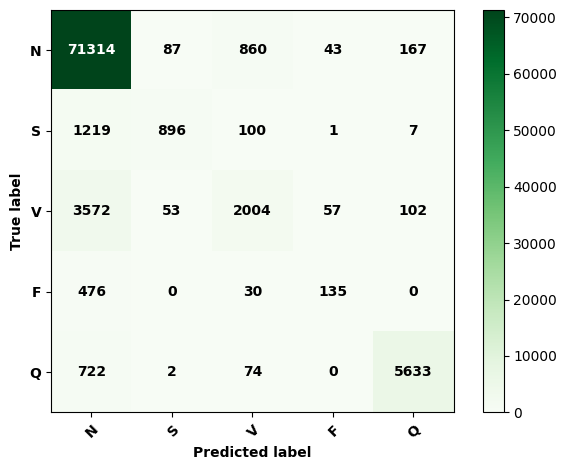

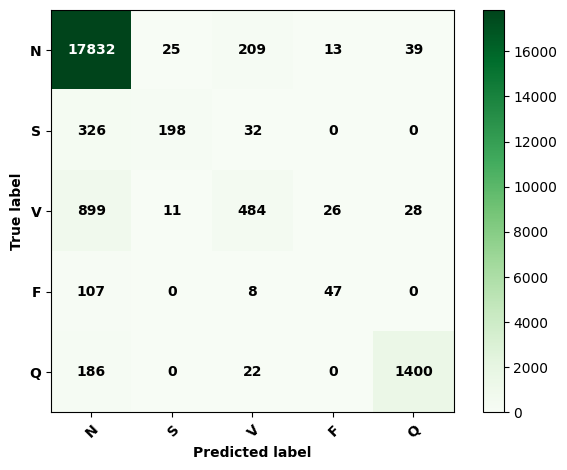

Accuracy (Train): 91.3516
Precision (Train): 79.2849
Recall (Train): 56.3970
F1 score (Train): 63.5044
Accuracy (Test): 91.1794
Precision (Test): 78.1921
Recall (Test): 56.7071
F1 score (Test): 63.6424


In [68]:
plot_score.plot_confusion_matrix(y_train, y_pred_lr_train)
plot_score.plot_confusion_matrix(y_test, y_pred_lr_test)
accuracy_lr_train, precision_lr_train, recall_lr_train, f1_lr_train = plot_score.score_train(y_train, y_pred_lr_train)
accuracy_lr_test, precision_lr_test, recall_lr_test, f1_lr_test = plot_score.score_test(y_test, y_pred_lr_test)

##### Decision Tree

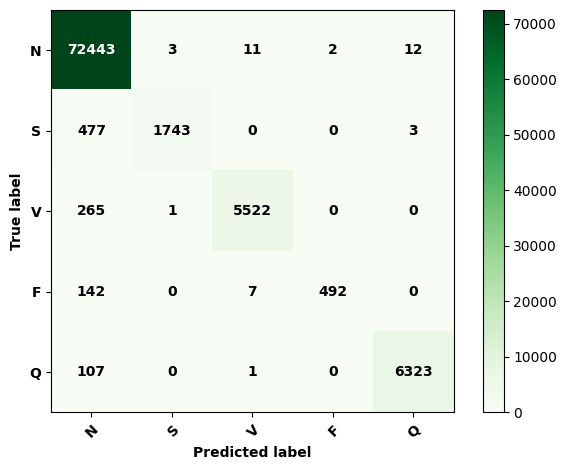

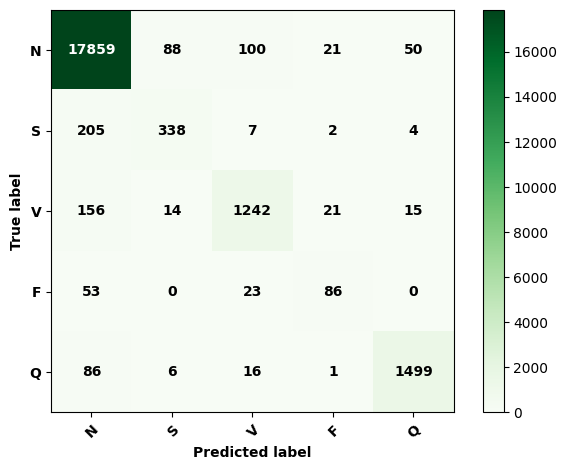

Accuracy (Train): 98.8224
Precision (Train): 99.4874
Recall (Train): 89.7698
F1 score (Train): 94.0655
Accuracy (Test): 96.0351
Precision (Test): 84.7582
Recall (Test): 78.2886
F1 score (Test): 81.2142


In [69]:
plot_score.plot_confusion_matrix(y_train, y_pred_dt_train)
plot_score.plot_confusion_matrix(y_test, y_pred_dt_test)
accuracy_dt_train, precision_dt_train, recall_dt_train, f1_dt_train = plot_score.score_train(y_train, y_pred_dt_train)
accuracy_dt_test, precision_dt_test, recall_dt_test, f1_dt_test = plot_score.score_test(y_test, y_pred_dt_test)

##### Linear NN

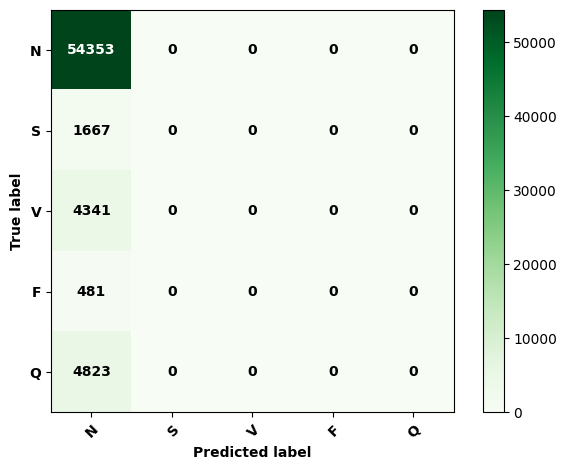

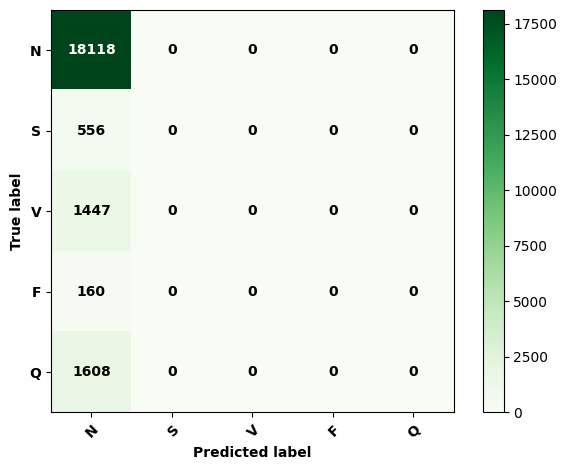

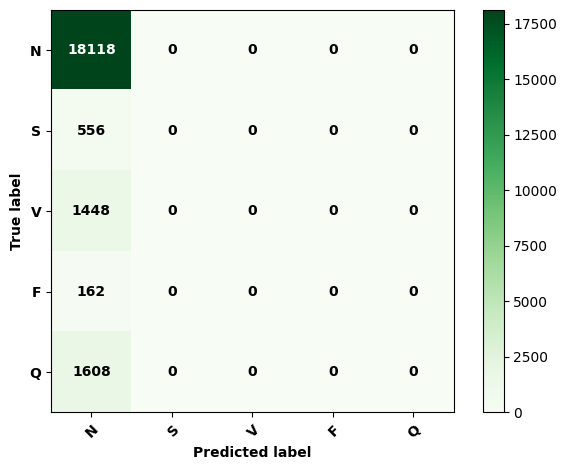

Accuracy (Train): 82.7732
Precision (Train): 16.5546
Recall (Train): 20.0000
F1 score (Train): 18.1149
Accuracy (Validation): 82.7722
Precision (Validation): 16.5544
Recall (Validation): 20.0000
F1 score (Validation): 18.1148
Accuracy (Test): 82.7608
Precision (Test): 16.5522
Recall (Test): 20.0000
F1 score (Test): 18.1135


g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
plot_score.plot_confusion_matrix(y_train_tensor, y_pred_nn_train.argmax(dim=1))
plot_score.plot_confusion_matrix(y_val_tensor, y_pred_nn_val.argmax(dim=1))
plot_score.plot_confusion_matrix(y_test_tensor, y_pred_nn_test.argmax(dim=1))
accuracy_nn_train, precision_nn_train, recall_nn_train, f1_nn_train = plot_score.score_train(y_train_tensor, y_pred_nn_train.detach().numpy().argmax(axis=1))
accuracy_nn_val, precision_nn_val, recall_nn_val, f1_nn_val = plot_score.score_val(y_val_tensor, y_pred_nn_val.detach().numpy().argmax(axis=1))
accuracy_nn_test, precision_nn_test, recall_nn_test, f1_nn_test = plot_score.score_test(y_test_tensor, y_pred_nn_test.detach().numpy().argmax(axis=1))

##### Non-Linear NN

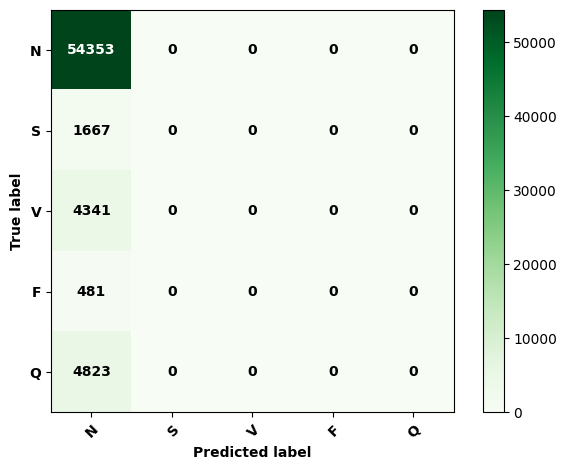

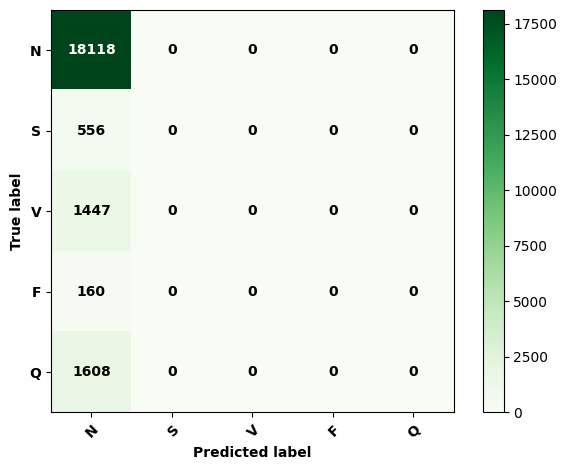

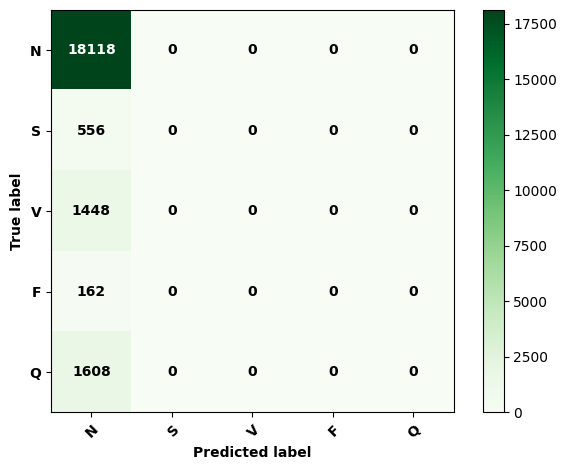

Accuracy (Train): 82.7732
Precision (Train): 16.5546
Recall (Train): 20.0000
F1 score (Train): 18.1149
Accuracy (Validation): 82.7722
Precision (Validation): 16.5544
Recall (Validation): 20.0000
F1 score (Validation): 18.1148
Accuracy (Test): 82.7608
Precision (Test): 16.5522
Recall (Test): 20.0000
F1 score (Test): 18.1135


g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
plot_score.plot_confusion_matrix(y_train_tensor, y_pred_mlp_train.argmax(dim=1))
plot_score.plot_confusion_matrix(y_val_tensor, y_pred_mlp_val.argmax(dim=1))
plot_score.plot_confusion_matrix(y_test_tensor, y_pred_mlp_test.argmax(dim=1))
accuracy_mlp_train, precision_mlp_train, recall_mlp_train, f1_mlp_train = plot_score.score_train(y_train_tensor, y_pred_mlp_train.detach().numpy().argmax(axis=1))
accuracy_mlp_val, precision_mlp_val, recall_mlp_val, f1_mlp_val = plot_score.score_val(y_val_tensor, y_pred_mlp_val.detach().numpy().argmax(axis=1))
accuracy_mlp_test, precision_mlp_test, recall_mlp_test, f1_mlp_test = plot_score.score_test(y_test_tensor, y_pred_mlp_test.detach().numpy().argmax(axis=1))

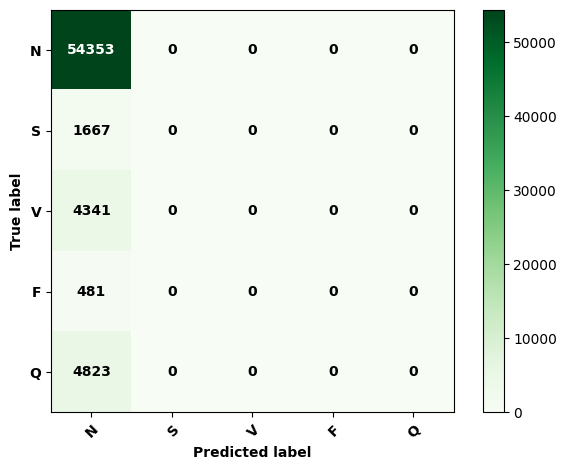

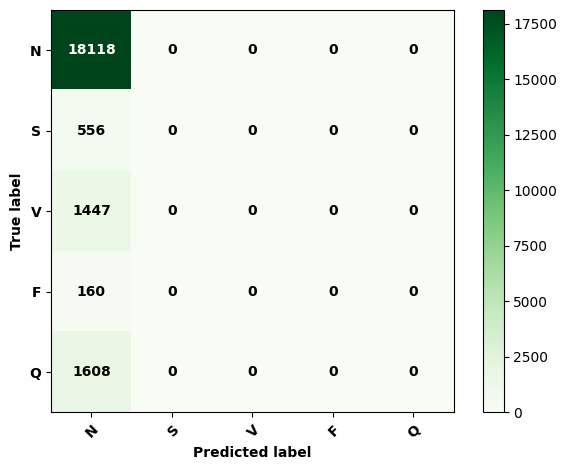

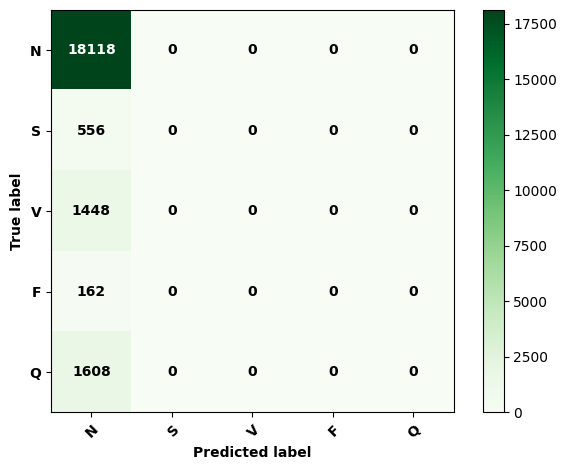

Accuracy (Train): 82.7732
Precision (Train): 16.5546
Recall (Train): 20.0000
F1 score (Train): 18.1149
Accuracy (Validation): 82.7722
Precision (Validation): 16.5544
Recall (Validation): 20.0000
F1 score (Validation): 18.1148
Accuracy (Test): 82.7608
Precision (Test): 16.5522
Recall (Test): 20.0000
F1 score (Test): 18.1135


g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
plot_score.plot_confusion_matrix(y_train_tensor, y_pred_mlp2_train.argmax(dim=1))
plot_score.plot_confusion_matrix(y_val_tensor, y_pred_mlp2_val.argmax(dim=1))
plot_score.plot_confusion_matrix(y_test_tensor, y_pred_mlp2_test.argmax(dim=1))
accuracy_mlp2_train, precision_mlp2_train, recall_mlp2_train, f1_mlp2_train = plot_score.score_train(y_train_tensor, y_pred_mlp2_train.detach().numpy().argmax(axis=1))
accuracy_mlp2_val, precision_mlp2_val, recall_mlp2_val, f1_mlp2_val = plot_score.score_val(y_val_tensor, y_pred_mlp2_val.detach().numpy().argmax(axis=1))
accuracy_mlp2_test, precision_mlp2_test, recall_mlp2_test, f1_mlp2_test = plot_score.score_test(y_test_tensor, y_pred_mlp2_test.detach().numpy().argmax(axis=1))

##### CNN

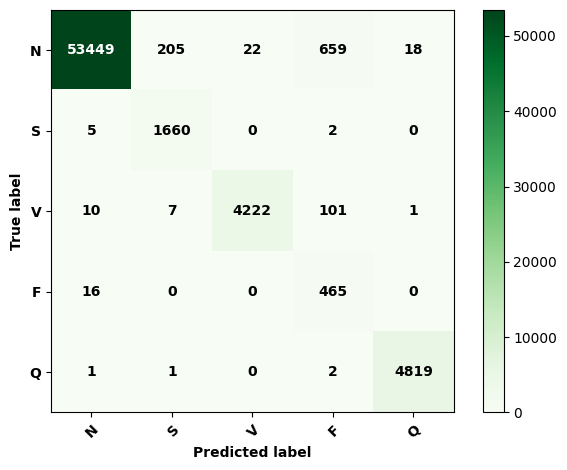

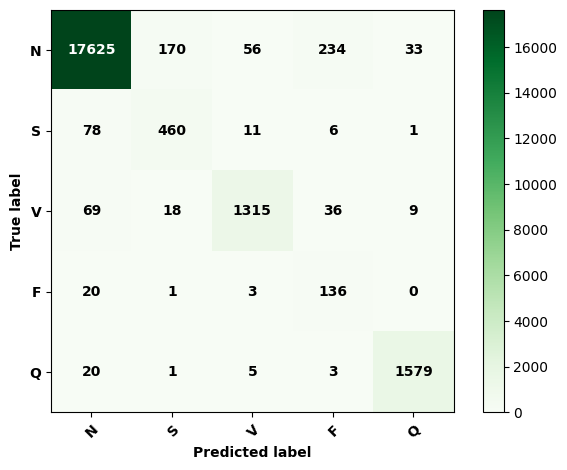

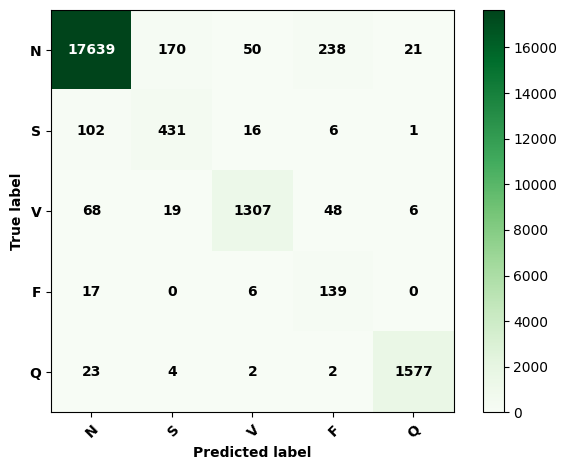

Accuracy (Train): 98.4010
Precision (Train): 85.0985
Recall (Train): 98.3532
F1 score (Train): 89.0846
Accuracy (Validation): 96.4640
Precision (Validation): 78.8887
Recall (Validation): 90.8174
F1 score (Validation): 82.4343
Accuracy (Test): 96.3503
Precision (Test): 78.5785
Recall (Test): 89.8022
F1 score (Test): 81.6843


In [73]:
plot_score.plot_confusion_matrix(y_train_tensor, y_pred_cnn_train.argmax(dim=1))
plot_score.plot_confusion_matrix(y_val_tensor, y_pred_cnn_val.argmax(dim=1))
plot_score.plot_confusion_matrix(y_test_tensor, y_pred_cnn_test.argmax(dim=1))
accuracy_cnn_train, precision_cnn_train, recall_cnn_train, f1_cnn_train = plot_score.score_train(y_train_tensor, y_pred_cnn_train.detach().numpy().argmax(axis=1))
accuracy_cnn_val, precision_cnn_val, recall_cnn_val, f1_cnn_val = plot_score.score_val(y_val_tensor, y_pred_cnn_val.detach().numpy().argmax(axis=1))
accuracy_cnn_test, precision_cnn_test, recall_cnn_test, f1_cnn_test = plot_score.score_test(y_test_tensor, y_pred_cnn_test.detach().numpy().argmax(axis=1))

In [74]:
all_model = pd.DataFrame(columns=['Model', 'Accuracy (Train)', 'Precision (Train)', 'Recall (Train)', 'F1 Score (Train)', 'Accuracy (Test)', 'Precision (Test)', 'Recall (Test)', 'F1 Score (Test)','Training Time','Testing Time'])
all_model.loc[0] = ['SVM',accuracy_svm_train,precision_svm_train,recall_svm_train,f1_svm_train,accuracy_svm_test,precision_svm_test,recall_svm_test,f1_svm_test,training_time_svm,testing_time_svm]
all_model.loc[1] = ['Logistic Regression',accuracy_lr_train,precision_lr_train,recall_lr_train,f1_lr_train,accuracy_lr_test,precision_lr_test,recall_lr_test,f1_lr_test,training_time_lr,testing_time_lr]
all_model.loc[2] = ['Decision Tree',accuracy_dt_train,precision_dt_train,recall_dt_train,f1_dt_train,accuracy_dt_test,precision_dt_test,recall_dt_test,f1_dt_test,training_time_dt,testing_time_dt]
all_model.loc[3] = ['Neural Network',accuracy_nn_train,precision_nn_train,recall_nn_train,f1_nn_train,accuracy_nn_test,precision_nn_test,recall_nn_test,f1_nn_test,training_time_nn,testing_time_nn]
all_model.loc[4] = ['Non-Linear NN',accuracy_mlp_train,precision_mlp_train,recall_mlp_train,f1_mlp_train,accuracy_mlp_test,precision_mlp_test,recall_mlp_test,f1_mlp_test,training_time_mlp,testing_time_mlp]
all_model.loc[5] = ['Non-Linear NN_batch training',accuracy_mlp2_train,precision_mlp2_train,recall_mlp2_train,f1_mlp2_train,accuracy_mlp2_test,precision_mlp2_test,recall_mlp2_test,f1_mlp2_test,training_time_mlp2,testing_time_mlp2]
all_model.loc[6] = ['CNN',accuracy_cnn_train,precision_cnn_train,recall_cnn_train,f1_cnn_train,accuracy_cnn_test,precision_cnn_test,recall_cnn_test,f1_cnn_test,training_time_cnn,testing_time_cnn]
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time,Testing Time
0,SVM,97.137766,95.156528,77.817231,84.534815,96.802485,92.860942,76.362044,82.885034,103.016522,34.128516
1,Logistic Regression,91.351623,79.284877,56.396990,63.504420,91.179426,78.192081,56.707081,63.642405,2.946872,0.006004
2,Decision Tree,98.822441,99.487420,89.769782,94.065452,96.035081,84.758181,78.288629,81.214199,30.256346,0.012003
3,Neural Network,82.773167,16.554633,20.000000,18.114949,82.760826,16.552165,20.000000,18.113472,34.126364,0.016000
4,Non-Linear NN,82.773167,16.554633,20.000000,18.114949,82.760826,16.552165,20.000000,18.113472,48.489898,0.022518
5,Non-Linear NN_batch training,82.773167,16.554633,20.000000,18.114949,82.760826,16.552165,20.000000,18.113472,253.774183,0.156511
6,CNN,98.400975,85.098514,98.353248,89.084561,96.350265,78.578522,89.802249,81.684349,2022.598987,0.774143


The results explains

....